# Graph attention networks applied to Tag-side reconstruction

In this notebook I apply a graph attention network implemented in pytorch geometric for the task of predicting if the reconstructed decay graph of a tag-side is correct.

### Define functions of producing adjacency matrices

In [1]:
import h5py
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

def recursive(index,dauindex, ndaus, matrix,nsum):
    if index != len(ndaus)-1:
        n = ndaus[index]
        tmp = nsum[0]
        for m in range(tmp,tmp+n):

            matrix[index,m] = 1
            matrix[m,index] = 1

            nsum[0] = nsum[0] + 1

        for m in range(tmp,tmp+n):
            if ndaus[m] > 0:
                recursive(m, nsum[0],ndaus,matrix,nsum)



def generate_adjacency(ndaus):
    index=0
    n=[1]
    matrix = np.zeros((len(ndaus),len(ndaus)))
    recursive(0,1,ndaus,matrix,n)
    invDsq = np.diag((1/np.sqrt(np.sum(matrix,axis=1))))
    np.nan_to_num(invDsq,0.)
    Laplacian = np.identity(len(ndaus)) + np.matmul(invDsq,np.matmul(matrix,invDsq))
    return matrix + np.identity(len(ndaus))

## Visualizing an adjacency matrix

The adjacency matrix summarises the connections of nodes in the graph (mother daughter relations for particles decays).

I stored the data in a certain format containing numbers of daughters in an array. The function generate_adjacency converts this format to the adjacency matrix.

In [2]:
import numpy as np
ndaus=np.array([2,2,0,2,2,0,0,0,0])

([<matplotlib.axis.XTick at 0x7fa1c84abee0>,
 [Text(0, 0, '$B^{+}$'),
  Text(1, 0, '$D^{0}$'),
  Text(2, 0, '$\\pi^{+}$'),
  Text(3, 0, '$K_{s}$'),
  Text(4, 0, '$\\pi^{0}$'),
  Text(5, 0, '$\\pi^{+}$'),
  Text(6, 0, '$\\pi^{+}$'),
  Text(7, 0, '$\\gamma$'),
  Text(8, 0, '$\\gamma$')])

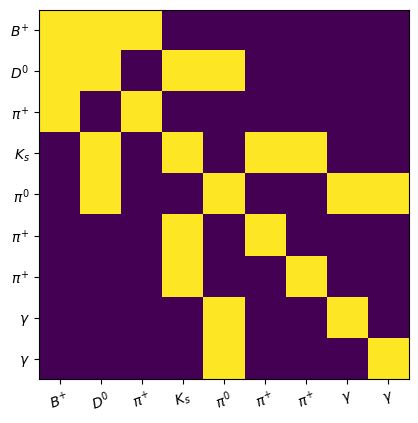

In [3]:
import matplotlib.pyplot as plt

plt.imshow(generate_adjacency(ndaus))
plt.yticks(list(range(0,9)),["$B^{+}$", r"$D^{0}$", r"$\pi^{+}$", r"$K_{s}$", r"$\pi^{0}$", r"$\pi^{+}$", r"$\pi^{+}$", r"$\gamma$", r"$\gamma$"])
plt.xticks(list(range(0,9)),["$B^{+}$", r"$D^{0}$", r"$\pi^{+}$", r"$K_{s}$", r"$\pi^{0}$", r"$\pi^{+}$", r"$\pi^{+}$", r"$\gamma$", r"$\gamma$"],rotation=20) 

## Data processing 

In [4]:
import glob
files = glob.glob("GraphFEI7/git_hash=light-2210-devonrex/*/feiHadronicBzero=True/feiHadronicBplus=True/*.hdf5")

In [5]:
len(files)

600

### Store Train Data

In [6]:
import h5py
data=[]
Xs=[]
count=0
Npars=[]
# We loop over 50 files to first determine a normalization
for file in files[:50]:
    f1 = h5py.File(file,'r+') 
    for event in f1.keys():
        for key in f1[event].keys():
            Btag = f1[event][key]
            ndaus = Btag.attrs['ndaughters']
            N = np.sum(ndaus) +1
            Npars.append(N)
            Btag.attrs['ndaughters'][0]
            # We always take data if its correct and randomly choose uncorrect tag-side candidates
            if not np.isnan(Btag.attrs['isSignal']) and not np.isnan(np.sum(np.array(Btag))) and (np.random.uniform(0,1,1)[0] < 0.5 or Btag.attrs['isSignal'] == 1):
                X = np.array(Btag) 
                #A = generate_adjacency([ndaus[0]] + (N-1)*[0])
                # Generate the adjacency
                A = generate_adjacency(ndaus)
                X = X[:, :]

                # Here we mask out certain features of the B
                X[0][0] = 0
                X[0][3] = 0
                X[0][4] = 0
                
                Xs.append(X)
                X = torch.tensor(X, dtype=torch.float)
                y = torch.tensor(Btag.attrs['isSignal'], dtype=torch.int64)
                edges =torch.tensor(A, dtype=torch.float).nonzero().t().contiguous() 
                data.append(Data(x=X, edge_index=edges,y=y,mbc=Btag.attrs['Mbc']))
                if  Btag.attrs['isSignal'] == 0:
                    count = count + 1

In [7]:
xmax = np.max(np.concatenate(Xs),axis=0)
xmin = np.min(np.concatenate(Xs),axis=0)

In [8]:
import h5py
data=[]
Xs=[]
count=0
Npars=[]
# We now loop over 200 files for the training set
for file in files[:570]:
    f1 = h5py.File(file,'r+') 
    for event in f1.keys():
        for key in f1[event].keys():
            Btag = f1[event][key]
            ndaus = Btag.attrs['ndaughters']
            N = np.sum(ndaus) +1
            Npars.append(N)
            Btag.attrs['ndaughters'][0]
            # We always take data if its correct and randomly choose uncorrect tag-side candidates
            if not np.isnan(Btag.attrs['isSignal']) and not np.isnan(np.sum(np.array(Btag))) and (np.random.uniform(0,1,1)[0] < 0.5 or Btag.attrs['isSignal'] == 1):
                # Normalize X
                X = np.array(Btag) /np.abs(xmax-xmin)

                A = generate_adjacency(ndaus)
                X = X[:, :]

                # Here we mask out certain features of the B
                X[0][0] = 0
                X[0][3] = 0
                X[0][4] = 0
                
                Xs.append(X)
                X = torch.tensor(X, dtype=torch.float)
                y = torch.tensor(Btag.attrs['isSignal'], dtype=torch.int64)
                edges =torch.tensor(A, dtype=torch.float).nonzero().t().contiguous() 
                data.append(Data(x=X, edge_index=edges,y=y,mbc=Btag.attrs['Mbc']))
                if  Btag.attrs['isSignal'] == 0:
                    count = count + 1

Text(0.5, 0, 'Number of particles in FEI reco decay')

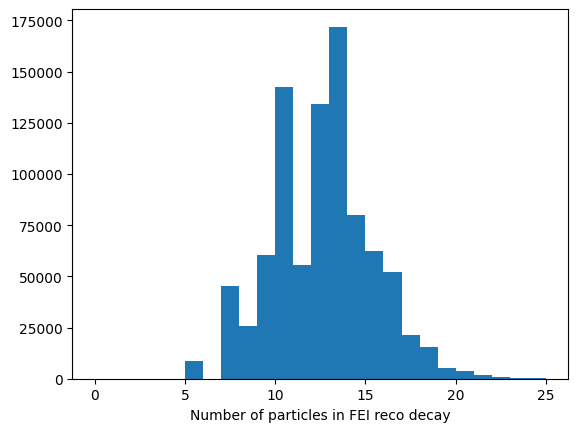

In [9]:
import matplotlib.pyplot as plt
plt.hist(Npars,range=(0,25),bins=25)
plt.xlabel('Number of particles in FEI reco decay')

In [10]:
count

251115

### Store Validation Data 

In [11]:
# Now store validation Data

valdata=[]
valXs=[]
valys=[]
count=0
feiprobs=[]
feimbcs =[]


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
for file in files[570:600]:
    f1 = h5py.File(file,'r+') 
    for event in f1.keys():
        for key in f1[event].keys():
            Btag = f1[event][key]
            ndaus = Btag.attrs['ndaughters']
            N = np.sum(ndaus[0]) +1
            N = np.sum(ndaus) +1
            Btag.attrs['ndaughters'][0]
            if not np.isnan(Btag.attrs['isSignal']) and not np.isnan(np.sum(np.array(Btag))) and (np.random.uniform(0,1,1)[0] < 0.5 or Btag.attrs['isSignal'] == 1):
                X = np.array(Btag)

                A = generate_adjacency(ndaus)
                X = X[:, :]/np.abs(xmax-xmin)

                feiprobs.append(X[0][0])
                feimbcs.append(Btag.attrs['Mbc'])
                X[0][0] = 0
                X[0][3] = 0
                X[0][4] = 0
                valXs.append(X)

                X = torch.tensor(X, dtype=torch.float)
                y = torch.tensor(Btag.attrs['isSignal'], dtype=torch.int64)
                valys.append(Btag.attrs['isSignal'])
                
                edges =torch.tensor(A, dtype=torch.float).nonzero().t().contiguous() 
                valdata.append(Data(x=X, edge_index=edges,y=y,mbc=Btag.attrs['Mbc']))
                if  Btag.attrs['isSignal'] == 0:
                    count = count + 1

## Data loaders

In [12]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

loader = DataLoader(data, batch_size=32, shuffle=True)
valloader = DataLoader(valdata, batch_size=32, shuffle=True)

## Define Model

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import NNConv, global_mean_pool
from torch import nn



class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.gconv1 = GATConv(18, self.hid, heads=self.in_head, dropout=0.2)
        self.gconv2 = GATConv(self.hid*self.in_head, 128, concat=False, droput=0.2)
        self.gconv3 = GATConv(128, 256, concat=False, droput=0.2)
        self.fc_1 = nn.Linear(256, 128)
        self.fc_2 = nn.Linear(128, 32)
        self.fc_3 = nn.Linear(32, 2)
        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.gconv1(x, edge_index)
        x = F.relu(x)
        x = self.gconv2(x, edge_index)
        x = F.relu(x)
        x = self.gconv3(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)

        return x
 


##  Training

In [22]:
losses = []
accuracy = []
vallosses = []
valaccuracy = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN().to(device)

In [35]:

optimizer_GCN = torch.optim.Adam(model.parameters(), lr=0.00001)

criterion = nn.CrossEntropyLoss()


for epoch in range(2):
    total = 0
    correct = 0
    valtotal = 0
    valcorrect = 0
    epoch_loss = 0 
    val_epoch_loss = 0
    train_eff_loss = 0 
    
    for b in loader:
        b.to(device)         
        optimizer_GCN.zero_grad()
        out = model(b)
        loss = criterion(out, b.y) 
        loss.backward()
        optimizer_GCN.step()
        ypred = torch.argmax(out,dim=1)
        total += b.y.size(0)
        epoch_loss += loss.item()/32

        correct += torch.sum(b.y == ypred).item()
        
    for b in valloader:
        b.to(device)
        out = model(b)
        valloss = criterion(out, b.y)
        ypred = torch.argmax(out,dim=1)
        valtotal += b.y.size(0)
        val_epoch_loss += valloss.item()/32

        valcorrect += torch.sum(b.y == ypred).item()
            
        
    print("Epoch ", epoch)    
    print("Training Loss ", epoch_loss)
    print("Training Accuracy % ", 100*correct/total)
    print("Val Loss ", val_epoch_loss)
    print("Val Accuracy % ", 100*valcorrect/valtotal)
    print("Training eff Loss ", train_eff_loss)

    losses.append(epoch_loss)
    accuracy.append(100*correct/total)
    vallosses.append(val_epoch_loss)
    valaccuracy.append(100*valcorrect/valtotal)
    print("")

Epoch  0
Training Loss  42.03802898839058
Training Accuracy %  96.8625595766232
Val Loss  2.320518562453799
Val Accuracy %  96.8100585755326
Training eff Loss  0

Epoch  1
Training Loss  41.99755712987826
Training Accuracy %  96.86295217381063
Val Loss  2.3046988677378977
Val Accuracy %  96.88094616274297
Training eff Loss  0



## Performance

### Define several variables of interest

In [36]:
ypreds=[]
ys=[]
mbcs =[]
for b in valloader:
    b.to(device)
    
    out = model(b)
    #ypreds=np.concatenate(ypreds)
    ypreds.append(torch.nn.Softmax(dim=1)(out)[:,1].detach().cpu().numpy())
    ys.append(b.y.detach().cpu().numpy())
    mbcs.append(b.mbc.detach().cpu().numpy())



In [37]:
ypreds=np.concatenate(ypreds)
ys=np.concatenate(ys)
mbcs=np.concatenate(mbcs)   

In [38]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import make_classification
import sklearn.model_selection
from sklearn import metrics

In [39]:
fpr, tpr, _ = metrics.roc_curve(ys,  ypreds)
fpr2, tpr2, _ = metrics.roc_curve(np.array(valys),  np.array(feiprobs))
#conf = metrics.confusion_matrix(y_train,  y_pred_train)
auc = metrics.roc_auc_score(ys,  ypreds)
auc2 = metrics.roc_auc_score(np.array(valys),  np.array(feiprobs))

In [40]:
np.array(feiprobs)

array([3.34328064e-02, 7.35289065e-01, 6.48846115e-01, ...,
       3.71847317e-05, 1.05966674e-04, 7.47062695e-05])

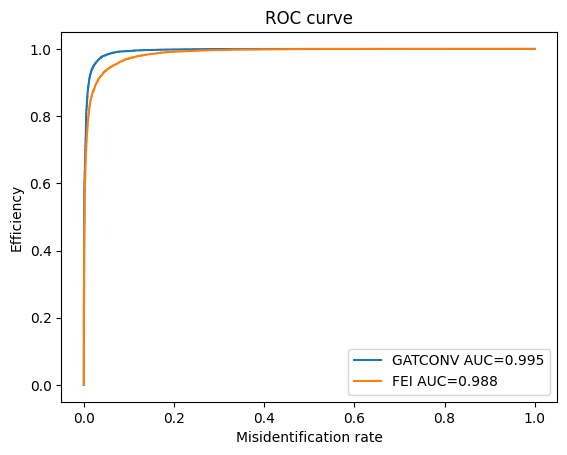

In [41]:
plt.plot(fpr,tpr,label="GATCONV AUC={:.3f}".format(auc))
plt.plot(fpr2,tpr2,label="FEI AUC={:.3f}".format(auc2))
#plt.plot(fpr,tpr_test,label="AUC={:.3f}".format(auc))
plt.ylabel('Efficiency')
plt.xlabel('Misidentification rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [46]:
epochs = np.arange(1, len(losses)+1)

In [47]:
len(losses)

12

Text(0, 0.5, 'Loss')

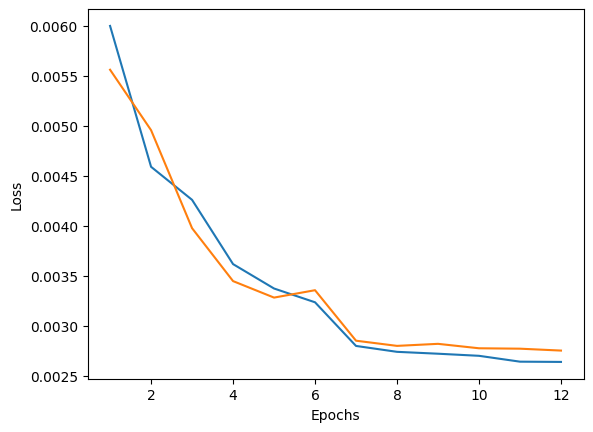

In [50]:
plt.plot(epochs,np.array(losses)*32./len(Xs))
plt.plot(epochs,np.array(vallosses)*32./len(valXs))
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

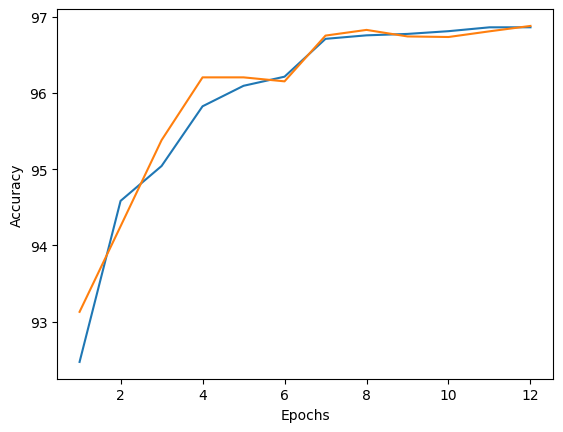

In [49]:
import matplotlib.pyplot as plt

plt.plot(epochs,accuracy)
plt.plot(epochs,valaccuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
